# Axes

The axes are referenced to the tool/carriage:

X - moves towards/away from the tool (perpendicular to the carriage).

Y - moves along the carriage axis

A - Yaw of the robot. I believe this rotates around the delivery point of the fibre (the tip of the final roller). The rotation is around the Z axis.

E1 - Rotation of the payout eye. 

E3/E4 - This rotates both chucks (headstock and tailstock) together, in a synchronised fashion. 


In [4]:
import re

class HPos:
    def __init__(self, P):
        self.X = P["X"]
        self.Y = P["Y"]
        assert P["Z"] == 0.0, P
        self.A = P["A"]
        assert P["B"] == 0.0, P
        assert P["C"] == 0.0, P
        self.E = P["E1"]
        self.H = P["E3"]
        assert P["E3"] == P["E4"], P
        
def linapply(P, y, brel):
    for e in y.split(","):
        k, v = e.split()
        if brel: # and k in "AXYZ":
            P[k] += float(v)
        else:
            P[k] = float(v)


reforblk = "(?s)LIN \{(.*?)\}\nHALT\n.*?PLY[^\(]*\(([^\)]*)\).*?FOR N_CYC=1 to (\d+)\n(.*?)ENDFOR"
def Hparse(fname):
    ftext = open(fname, "r").read()
    forblks = re.findall(reforblk, ftext)

    Pblocks = [ ]
    P = { "E3":0.0, "E4":0.0, "Z":0.0 }
    for bknum, forblk in enumerate(forblks):
        P["E3"] = P["E4"] = 0
        linapply(P, forblk[0], False)
        Ps = [ HPos(P) ]
        #print(P["Y"], forblk[0])
        lins = re.findall("LIN_REL \{(.*?)\}", forblk[3])
        k1 = Ps[-1]
        Ncycles = int(forblk[2])
        for N_CYC in range(Ncycles):
            for lin in lins:
                linapply(P, lin, True)
                Ps.append(HPos(P))
                #assert bknum <= 5 or P.get("E3", 0) < 10000, (bknum, P)
        Pblocks.append({"H":Ps, "plytype":forblk[1], "Ncycles":Ncycles})
    return Pblocks

In [5]:
HBs = Hparse("output/Vessel04speedt3.src")
min(min(h.x  for h in HB for HB in HBs))


In [28]:
print("Xrange", min(min(h.X  for h in HB["H"])  for HB in HBs), max(max(h.X  for h in HB["H"])  for HB in HBs))
print("Yrange", min(min(h.Y  for h in HB["H"])  for HB in HBs), max(max(h.Y  for h in HB["H"])  for HB in HBs))


Xrange -174.367 -72.67100000000002
Yrange 154.19999999999962 1736.9069999999997


In [29]:
from barmesh.tribarmes import trianglebarmesh
from barmesh.basicgeo import P3
import barmesh.geodesicUtils as geo

fname = 'geometry/PV/PV-med.stl'
#fname = 'geometry/PPR-fine/PPR-fine.stl'
tbm = trianglebarmesh.TriangleBarMesh(fname)
print("Xrange", min(node.p.x for node in tbm.nodes), max(node.p.x for node in tbm.nodes))
print("Yrange", min(node.p.y for node in tbm.nodes), max(node.p.y for node in tbm.nodes))
print("Zrange", min(node.p.z for node in tbm.nodes), max(node.p.z for node in tbm.nodes))

print("!! radius is 125mm, but length ends at 869")
print("which is too short for this to match the toolpath")

Xrange -125.00025177001953 125.00004577636719
Yrange -3.5580224990844727 869.5830078125
Zrange -125.000244140625 125.00025177001953
!! radius is 125mm, but length ends at 869
which is too short for this to match the toolpath


Text(0.5, 1.0, '41 separated blocks')

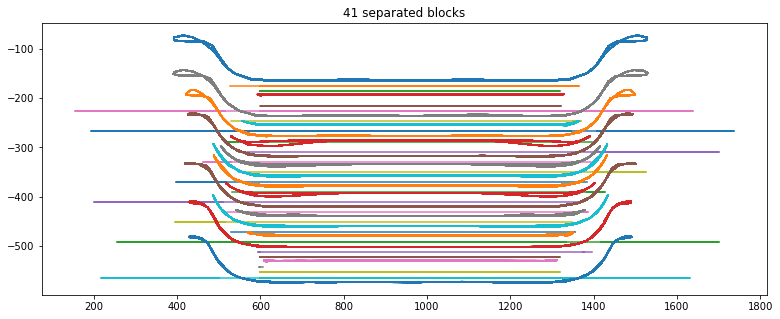

In [33]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(13,5))
for i, HB in enumerate(HBs):
    plt.plot([h.Y for h in H], [h.X -i*10 for h in H])
plt.title("41 separated blocks")

In [52]:
segs = [ ]
for hp, h in zip(H, H[1:]):
    if cylow < hp.Y < cyhigh and cylow < h.Y < cyhigh:
        segs.append([[hp.Y, hp.X], [h.Y, h.X]])
segs

[[[814.6870000000001, -162.454], [860.6990000000001, -162.73600000000002]],
 [[860.6990000000001, -162.73600000000002], [904.527, -163.56400000000002]],
 [[904.527, -163.56400000000002], [970.037, -164.52700000000002]],
 [[970.037, -164.52700000000002], [1043.988, -164.491]],
 [[1169.0469999999996, -163.083], [1106.2879999999996, -162.454]],
 [[1106.2879999999996, -162.454], [1060.2259999999997, -162.73600000000002]],
 [[1060.2259999999997, -162.73600000000002],
  [1016.3539999999997, -163.56400000000002]],
 [[1016.3539999999997, -163.56400000000002],
  [950.7699999999998, -164.52700000000002]],
 [[950.7699999999998, -164.52700000000002], [876.7299999999998, -164.491]],
 [[814.6869999999999, -162.45400000000004],
  [860.6989999999998, -162.73600000000005]],
 [[860.6989999999998, -162.73600000000005],
  [904.5269999999998, -163.56400000000005]],
 [[904.5269999999998, -163.56400000000005],
  [970.0369999999998, -164.52700000000004]],
 [[970.0369999999998, -164.52700000000004],
  [1043.98

Text(0.5, 1.0, 'Wide spread of distances from the mandrel')

<Figure size 936x360 with 0 Axes>

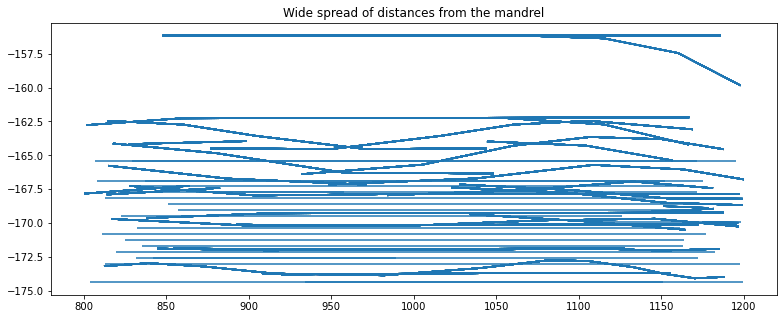

In [56]:
# Focus onto the easy to manage cylindrical section...

cylow, cyhigh = 800, 1200
from matplotlib.collections import LineCollection

fig = plt.figure(figsize=(13,5))
ax = plt.gca()

for HB in HBs:
    H = HB["H"]
    segs = [ ]
    for hp, h in zip(H, H[1:]):
        if cylow < hp.Y < cyhigh and cylow < h.Y < cyhigh:
            segs.append([[hp.Y, hp.X], [h.Y, h.X]])
    ax.add_collection(LineCollection(segs))
plt.plot()

plt.title("Wide spread of distances from the mandrel")

In [59]:
len(H[

3305

In [74]:
fig.subplot

AttributeError: 'Figure' object has no attribute 'subplot'

[]

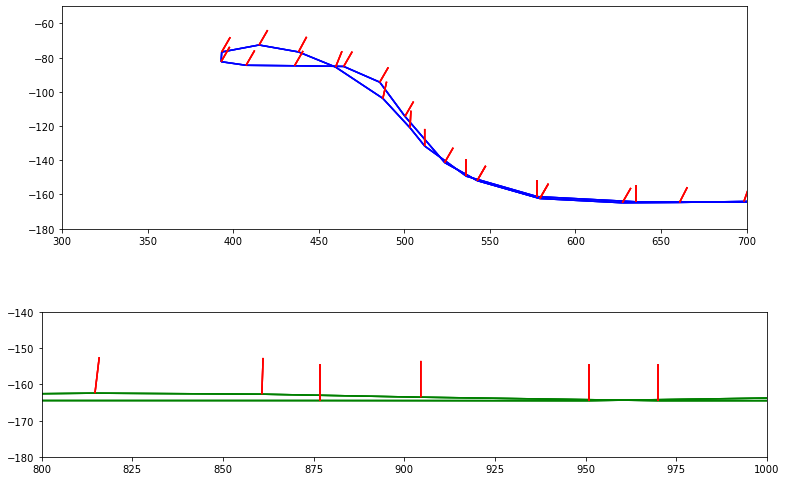

In [90]:
import math

H = HBs[0]["H"]
H = H[:180]
segs = [ ]
yaws = [ ]
for hp, h in zip(H, H[1:]):
    segs.append([[hp.Y, hp.X], [h.Y, h.X]])
    yvec = (10*math.cos(math.radians(h.A)), 10*math.sin(math.radians(h.A)))
    yaws.append([[h.Y, h.X], [h.Y+yvec[1], h.X+yvec[0]]])

fig = plt.figure(figsize=(13,9))
ax = plt.subplot(2,1,2)
ax.set_aspect('equal')
ax.add_collection(LineCollection(segs, color="green"))
ax.add_collection(LineCollection(yaws, color="red"))
ax.set_xlim(800, 1000)
ax.set_ylim(-180, -140)

ax = plt.subplot(2,1,1)
ax.set_aspect('equal')
ax.add_collection(LineCollection(segs, color="blue"))
ax.add_collection(LineCollection(yaws, color="red"))
ax.set_xlim(300, 700)
ax.set_ylim(-180, -50)

plt.plot()


In [ ]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
ax.add_collection3d(Line3DCollection(poly3d, colors='k', linewidths=0.2, linestyles=':'))
